In [2]:
# Import libraries
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# NLTK VADER for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

finwiz_url = 'https://finviz.com/quote.ashx?t='

In [3]:
news_tables = {}
tickers = ['AMZN', 'TSLA', 'GOOG']

for ticker in tickers:
    url = finwiz_url + ticker
    req = Request(url=url,headers={'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:20.0) Gecko/20100101 Firefox/20.0'})
    response = urlopen(req)
    # Read the contents of the file into 'html'
    html = BeautifulSoup(response)
    # Find 'news-table' in the Soup and load it into 'news_table'
    news_table = html.find(id='news-table')
    # Add the table to our dictionary
    news_tables[ticker] = news_table

In [4]:
# Read one single day of headlines for 'AMZN'
amzn = news_tables['AMZN']
# Get all the table rows tagged in HTML with <tr> into 'amzn_tr'
amzn_tr = amzn.findAll('tr')

for i, table_row in enumerate(amzn_tr):
    # Read the text of the element 'a' into 'link_text'
    a_text = table_row.a.text
    # Read the text of the element 'td' into 'data_text'
    td_text = table_row.td.text
    # Print the contents of 'link_text' and 'data_text'
    print(a_text)
    print(td_text)
    # Exit after printing 4 rows of data
    if i == 3:
        break

Amazon Fuel-Inflation Fee Has Sellers Poised to Raise Prices
Apr-13-22 05:50PM  
Amazon to hit U.S. third-party sellers with 5% inflation and fuel surcharge
04:41PM  
Tesla, Amazon, Nvidia lead markets toward session highs
04:21PM  
Is Amazon Stock A Buy Now That It Plans A 20-For-1 Split And Buyback?
03:47PM  


In [5]:
parsed_news = []

# Iterate through the news
for file_name, news_table in news_tables.items():
    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        # read the text from each tr tag into text
        # get text from a only
        text = x.a.get_text()
        # splite text in the td tag into a list
        date_scrape = x.td.text.split()
        # if the length of 'date_scrape' is 1, load 'time' as the only element

        if len(date_scrape) == 1:
            time = date_scrape[0]

        # else load 'date' as the 1st element and 'time' as the second
        else:
            date = date_scrape[0]
            time = date_scrape[1]
        # Extract the ticker from the file name, get the string up to the 1st '_'
        ticker = file_name.split('_')[0]

        # Append ticker, date, time and headline as a list to the 'parsed_news' list
        parsed_news.append([ticker, date, time, text])

parsed_news

[['AMZN',
  'Apr-13-22',
  '05:50PM',
  'Amazon Fuel-Inflation Fee Has Sellers Poised to Raise Prices'],
 ['AMZN',
  'Apr-13-22',
  '04:41PM',
  'Amazon to hit U.S. third-party sellers with 5% inflation and fuel surcharge'],
 ['AMZN',
  'Apr-13-22',
  '04:21PM',
  'Tesla, Amazon, Nvidia lead markets toward session highs'],
 ['AMZN',
  'Apr-13-22',
  '03:47PM',
  'Is Amazon Stock A Buy Now That It Plans A 20-For-1 Split And Buyback?'],
 ['AMZN',
  'Apr-13-22',
  '03:33PM',
  'Great Resignation: Talent is really in control, CEO says'],
 ['AMZN',
  'Apr-13-22',
  '03:17PM',
  'Markets check: Stocks head higher as earnings season kicks off'],
 ['AMZN',
  'Apr-13-22',
  '03:16PM',
  "Amazon's 'Just Walk Out' technology coming to Houston's Minute Maid Park"],
 ['AMZN',
  'Apr-13-22',
  '03:15PM',
  'Amazon hits US sellers with surcharge to offset inflation and fuel costs'],
 ['AMZN',
  'Apr-13-22',
  '03:10PM',
  'Is Snowflake Stock A Buy Or Sell Amid Software Sector Volatility?'],
 ['AMZN',

In [6]:
# Instantiate the sentiment intensity analyzer
vader = SentimentIntensityAnalyzer()

# Set column names
columns = ['ticker', 'date', 'time', 'headline']

# Convert the parsed_news list into a DataFrame called 'parsed_and_scored_news'
parsed_and_scored_news = pd.DataFrame(parsed_news, columns=columns)

# Iterate through the headlines and get the polarity scores using vader
scores = parsed_and_scored_news['headline'].apply(vader.polarity_scores).tolist()

# Convert the 'scores' list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)

# Join the DataFrames of the news and the list of dicts
parsed_and_scored_news = parsed_and_scored_news.join(scores_df, rsuffix='_right')

# Convert the date column from string to datetime
parsed_and_scored_news['date'] = pd.to_datetime(parsed_and_scored_news.date).dt.date

parsed_and_scored_news.head()

,ticker,date,time,headline,neg,neu,pos,compound
0,AMZN,2022-04-13,05:50PM,Amazon Fuel-Inflation Fee Has Sellers Poised t...,0.000,0.654,0.346,0.4019
1,AMZN,2022-04-13,04:41PM,Amazon to hit U.S. third-party sellers with 5%...,0.000,0.866,0.134,0.1779
2,AMZN,2022-04-13,04:21PM,"Tesla, Amazon, Nvidia lead markets toward sess...",0.000,0.805,0.195,0.1779
3,AMZN,2022-04-13,03:47PM,Is Amazon Stock A Buy Now That It Plans A 20-F...,0.000,0.866,0.134,0.1779
4,AMZN,2022-04-13,03:33PM,Great Resignation: Talent is really in control...,0.146,0.397,0.457,0.6908


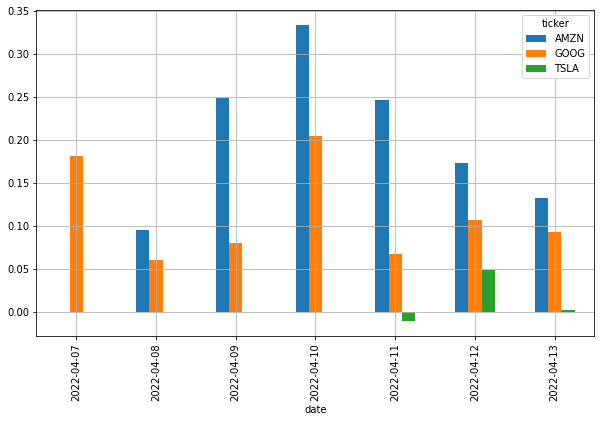

In [7]:
plt.rcParams['figure.figsize'] = [10, 6]

# Group by date and ticker columns from scored_news and calculate the mean
mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()

# Unstack the column ticker
mean_scores = mean_scores.unstack()

# Get the cross-section of compound in the 'columns' axis
mean_scores = mean_scores.xs('compound', axis="columns").transpose()

# Plot a bar chart with pandas
mean_scores.plot(kind = 'bar')
plt.grid()